In [387]:
import abc
from collections import UserList

import numpy as np
from scipy.spatial.transform import Rotation


class Transform:

    __slots__ = ('_panval', '_tiltval', '_focus', '_transform')

    def __init__(self, pan=0, tilt=0, focus=(0, 0, 0)):
        self.panval, self.tiltval = pan, tilt
        self._focus = np.array(focus, dtype=float)

    @property
    def panval(self, /):
        return self._panval

    @panval.setter
    def panval(self, val, /):
        self._panval = float(val)
        try:
            del self._transform
        except AttributeError:
            pass

    @property
    def tiltval(self, /):
        return self._tiltval

    @tiltval.setter
    def tiltval(self, val, /):
        self._tiltval = float(val)
        try:
            del self._transform
        except AttributeError:
            pass

    def pan(self, val, /):
        self.panval += val

    def tilt(self, val, /):
        self.tiltval += val

    @property
    def focus(self, /):
        return self._focus

    @focus.setter
    def focus(self, val, /):
        self._focus[...] = val

    @property
    def transform(self, /):
        try:
            return self._transform
        except AttributeError:
            transform = self._transform = \
                Rotation.from_euler('zx', (-self.panval, -self.tiltval), degrees=True)
            return transform

    def __call__(self, arr, /):
        return self.transform.apply(np.array(arr) - self.focus)


class Projection:

    __slots__ = ('_width', '_height', '_scaleval')

    def __init__(self, width=424, height=300, scale=1):
        self.width, self.height, self.scaleval = width, height, scale

    @property
    def width(self, /):
        return self._width

    @width.setter
    def width(self, val, /):
        self._width = int(val)

    @property
    def height(self, /):
        return self._height

    @height.setter
    def height(self, val, /):
        self._height = int(val)

    @property
    def scale(self, /):
        return self._scaleval

    @scale.setter
    def scaleval(self, val, /):
        self._scaleval = float(val)

    def scale(self, val, /):
        self.scaleval *= val

    def __call__(self, arg, /):
        arr = np.array(arg) * self.scaleval
        arr[:, 0] += self.width / 2
        arr[:, 1] = self.height / 2 - arr[:, 1]
        return arr[:, :-1]


class View:

    __slots__ = ('_projection', '_transform')

    def __init__(self, projection, transform):
        self._projection, self._transform = projection, transform

    @property
    def projection(self, /):
        return self._projection

    @property
    def transform(self, /):
        return self._transform

    def __call__(self, entity, /):
        return self.projection(self.transform(entity))


class Canvas:

    __slots__ = ('elements', '_view',)

    def __init__(self, view = None):
        super().__init__()
        if view is None:
            view = View(Projection(), Transform())
        self._view = view
        self.elements = []

    def add(self, obj, /, *objs):
        if isinstance(obj, Compound):
            self.elements.extend(obj.elements)
        else:
            self.elements.append(obj)
        if objs:
            for obj in objs:
                self.add(obj)

    @property
    def view(self, /):
        return self._view

    @property
    def projection(self, /):
        return self.view.projection

    @property
    def transform(self, /):
        return self.view.transform

    def draw_svg(self, /):
        return (
            f'''<svg '''
            f'''width="{self.projection.width}" height="{self.projection.height}" '''
            f'''style="background-color:white"'''
            f'''>'''
            f'''{' '.join(element.draw(self.view) for element in self.elements)}'''
            '''</svg>'''
            )

    def _repr_svg_(self):
        return self.draw_svg()


class Element:

    @abc.abstractmethod
    def __array__(self, /):
        raise NotImplementedError

    @abc.abstractmethod
    def draw(self, view, /):
        raise NotImplementedError


class Flat(Element):

    _omap = {
        'xy': (0, 1, 2),
        'xz': (0, 2, 1),
        'yz': (1, 2, 0),
        }

    __slots__ = ('_u0', '_u1', '_v0', '_v1', '_orientation', '_fill', '_fixed')

    def __init__(self, orientation, u0, u1, v0, v1, fixed, fill='black'):
        self.orientation = str(orientation)
        self.fill = fill
        self.u0, self.u1, self.v0, self.v1, self.fixed = u0, u1, v0, v1, fixed

    @property
    def orientation(self, /):
        return self._orientation

    @orientation.setter
    def orientation(self, val, /):
        val = str(val)
        if val not in self._omap:
            raise ValueError(val)
        self._orientation = val

    @property
    def fill(self, /):
        return self._fill

    @fill.setter
    def fill(self, val, /):
        self._fill = str(val)

    @property
    def u0(self, /):
        return self._u0

    @u0.setter
    def u0(self, val, /):
        self._u0 = float(val)

    @property
    def u1(self, /):
        return self._u1

    @u1.setter
    def u1(self, val, /):
        self._u1 = float(val)

    @property
    def v0(self, /):
        return self._v0

    @v0.setter
    def v0(self, val, /):
        self._v0 = float(val)

    @property
    def v1(self, /):
        return self._v1

    @v1.setter
    def v1(self, val, /):
        self._v1 = float(val)

    @property
    def fixed(self, /):
        return self._fixed

    @fixed.setter
    def fixed(self, val, /):
        self._fixed = float(val)    

    @property
    def ul(self, /):
        return self.u1 - self.u0

    @ul.setter
    def ul(self, val, /):
        mid = (self.u0 + self.u1) / 2
        val = val / 2
        self.u0 = mid - val
        self.u1 = mid + val

    @property
    def vl(self, /):
        return self.v1 - self.v0

    @vl.setter
    def vl(self, val, /):
        mid = (self.v0 + self.v1) / 2
        val = val / 2
        self.v0 = mid - val
        self.v1 = mid + val

    def uscale(self, val, /):
        self.ul *= val

    def vscale(self, val, /):
        self.vl *= val

    def scale(self, val):
        self.uscale(val)
        self.vscale(val)

    @property
    def uc(self, /):
        return (self.u0 + self.u1) / 2

    @uc.setter
    def uc(self, val, /):
        half = self.ul / 2
        self.u0 = val - half
        self.u1 = val + half

    @property
    def vc(self, /):
        return (self.v0 + self.v1) / 2

    @vc.setter
    def vc(self, val, /):
        half = self.vl / 2
        self.v0 = val - half
        self.v1 = val + half

    def __array__(self, /):
        out = np.empty((4, 3), dtype=float)
        ud, vd, fd = self._omap[self.orientation]
        out[:, ud] = (self.u0, self.u0, self.u1, self.u1)
        out[:, vd] = (self.v0, self.v1, self.v1, self.v0)
        out[:, fd] = self.fixed
        return out

    def draw(self, view, /):
        arr = view(self)
        pointstr = ' '.join(f"{x},{y}" for x, y in arr)
        return f'''<polygon fill="{self.fill}" points="{pointstr}"/>'''


class Compound:

    @abc.abstractmethod
    def elements(self, /) -> tuple:
        raise NotImplementedError


class Box(Compound):

    __slots__ = (
        '_lv', '_rv', '_nv', '_fv', '_bv', '_tv',
        '_left', '_right', '_near', '_far', '_bottom', '_top',
        )

    def __init__(self, left, right, near, far, bottom, top):
        self.lv, self.rv, self.nv, self.fv, self.bv, self.tv = \
            (left, right, near, far, bottom, top)
        self._left, self._right, self._near, self._far, self._bottom, self._top = (
            self._make_flat(side) for side in (
                'left', 'right', 'near', 'far', 'bottom', 'top'
                )
            )

    @property
    def lv(self, /):
        return self._lv

    @lv.setter
    def lv(self, val, /):
        self._lv = float(val)

    @property
    def rv(self, /):
        return self._rv

    @rv.setter
    def rv(self, val, /):
        self._rv = float(val)

    @property
    def nv(self, /):
        return self._nv

    @nv.setter
    def nv(self, val, /):
        self._nv = float(val)

    @property
    def fv(self, /):
        return self._fv

    @fv.setter
    def fv(self, val, /):
        self._fv = float(val)

    @property
    def bv(self, /):
        return self._bv

    @bv.setter
    def bv(self, val, /):
        self._bv = float(val)

    @property
    def tv(self, /):
        return self._tv

    @tv.setter
    def tv(self, val, /):
        self._tv = float(val)

    def _make_flat(self, side, /, **kwargs):
        if side in ('bottom', 'top'):
            orientation = 'xy'
            vals = self.lv, self.rv, self.nv, self.fv
        elif side in ('near', 'far'):
            orientation = 'xz'
            vals = self.lv, self.rv, self.bv, self.tv
        elif side in ('left', 'right'):
            orientation = 'yz'
            vals = self.nv, self.fv, self.bv, self.tv
        else:
            raise ValueError(side)
        return Flat(orientation, *vals, getattr(self, side[0]+'v'))

    @property
    def breadth(self, /):
        return self.rv - self.lv

    @property
    def depth(self, /):
        return self.fv - self.nv

    @property
    def height(self, /):
        return self.tv - self.bv

    @property
    def centre(self, /):
        return (
            (self.lv + self.breadth / 2),
            (self.nv + self.depth / 2),
            (self.bv + self.height / 2),
            )

    @property
    def left(self, /):
        return self._left

    @property
    def right(self, /):
        return self._right

    @property
    def near(self, /):
        return self._near

    @property
    def far(self, /):
        return self._far

    @property
    def bottom(self, /):
        return self._bottom

    @property
    def top(self, /):
        return self._top

    @property
    def elements(self, /):
        return (self.left, self.right, self.near, self.far, self.bottom, self.top)


class Hollow(Box):

    @property
    def floor(self, /):
        return self.bottom

    @property
    def back(self, /):
        return self.far

    @property
    def side(self, /):
        return self.right

    @property
    def elements(self, /):
        return (self.floor, self.back, self.side)


class Solid(Box):

    @property
    def front(self, /):
        return self.near

    @property
    def side(self, /):
        return self.left

    @property
    def roof(self, /):
        return self.top

    @property
    def elements(self, /):
        return (self.front, self.side, self.roof)

In [402]:
class Person(Solid):

    __slots__ = ('_location',)

    def __init__(self, x, y, width=0.4, height=1.7):
        hwidth = width / 2
        super().__init__(x-hwidth, x+hwidth, y-hwidth, y+hwidth, 0, height)
        self.front.fill = 'antiquewhite'
        self.side.fill = 'beige'
        self.roof.fill = 'bisque'


class Room(Hollow):

    __slots__ = ('_door',)

    def __init__(self, breadth, depth, height):
        super().__init__(0, breadth, 0, depth, 0, height)
        self.back.fill = 'steelblue'
        self.side.fill = 'lightskyblue'
        self.floor.fill = 'lightblue'
        self._door = ...

    @property
    def door(self, /):
        return self._door

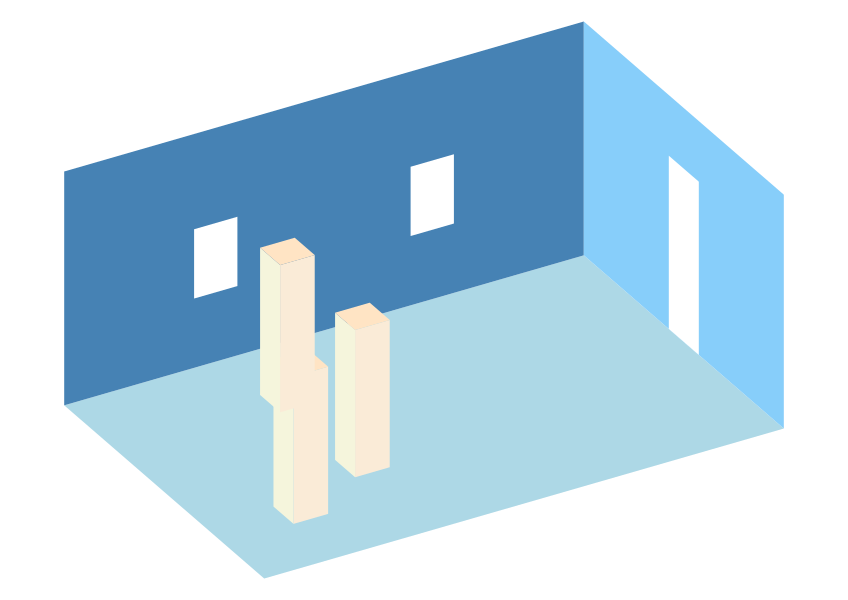

In [422]:
canvas = Canvas()
canvas.projection.width *= 2
canvas.projection.height *= 2
canvas.projection.scale(2)
room = Room(6, 4, 2.7)
floor, wall0, wall1 = room.bottom, room.far, room.right
window1 = Flat('xz', room.lv+1.5, room.lv+2, room.bv+0.8, room.bv+1.6, room.fv, fill='white')
window2 = Flat('xz', room.rv-1.5, room.rv-2, room.bv+0.8, room.bv+1.6, room.fv, fill='white')
door = Flat('yz', wall1.uc-0.3, wall1.uc+0.3, 0, 2, room.rv, fill='white')
person1 = Person(1, 1)
person2 = Person(2, 1.5)
person3 = Person(2, 3)
canvas.add(room)
canvas.add(window1, window2, door)
canvas.add(person1, person2, person3)
# canvas.extend((floor, wall0, window1, window2, door))
canvas.transform.focus = room.centre
canvas.transform.pan(-30)
canvas.transform.tilt(60)
canvas.projection.scale(50)
display(canvas)

In [420]:
canvas._repr_svg_()

'<svg width="424" height="300" style="background-color:white"><polygon fill="lightblue" points="92.99303056689185,250.2480879906792 41.22922154638769,200.2480879906792 331.00696943310817,180.151898558345 382.7707784536123,230.151898558345"/> <polygon fill="steelblue" points="41.22922154638769,200.2480879906792 41.22922154638769,69.848101441655 331.00696943310817,49.751912009320804 331.00696943310817,180.151898558345"/> <polygon fill="lightskyblue" points="382.7707784536123,230.151898558345 382.7707784536123,99.75191200932079 331.00696943310817,49.751912009320804 331.00696943310817,180.151898558345"/> <polygon fill="white" points="113.67365851806781,156.58700758103294 113.67365851806781,117.94997452947021 137.82180417529452,116.27529207677568 137.82180417529452,154.91232512833844"/> <polygon fill="white" points="258.562532461428,146.53891286486584 258.562532461428,107.90187981330311 234.41438680420134,109.57656226599764 234.41438680420134,148.21359531756036"/> <polygon fill="white" poin

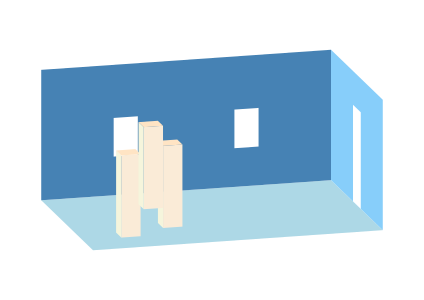

In [419]:
canvas.transform.pan(15)
canvas.transform.tilt(15)
canvas

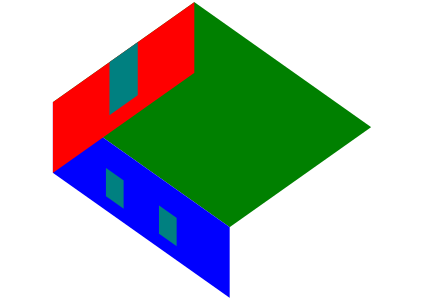

In [311]:
canvas.transform.pan(15)
canvas.transform.tilt(15)
canvas

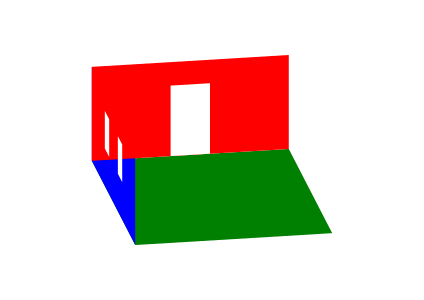

In [56]:
canvas.transform.tilt(10)
canvas

In [40]:
canvas._repr_svg_()

'<svg width="424" height="300" style="background-color:white"><polygon fill="green" points="236.10254037844385,226.7207631815113 62.89745962155615,209.35594541481828 187.89745962155615,171.76001211970947 361.10254037844385,189.1248298864025"/> <polygon fill="blue" points="62.89745962155615,209.35594541481828 62.89745962155615,110.8751701135975 187.89745962155615,73.27923681848868 187.89745962155615,171.76001211970947"/> <polygon fill="red" points="361.10254037844385,189.1248298864025 361.10254037844385,90.64405458518172 187.89745962155615,73.27923681848868 187.89745962155615,171.76001211970947"/> <polygon fill="white" points="100.39745962155614,158.68485530579733 100.39745962155614,119.29254518530901 112.89745962155614,115.53295185579813 112.89745962155615,154.92526197628644"/> <polygon fill="white" points="150.39745962155615,143.6464819877538 150.39745962155615,104.25417186726548 137.89745962155615,108.01376519677635 137.89745962155615,147.40607531726468"/> <polygon fill="white" point